In [1]:
import os
import pathlib
import sys

import implicit
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd

project_path = pathlib.Path(os.getcwd()).parent
sys.path.append(project_path.as_posix())

import random
from collections import defaultdict

from catboost import CatBoostClassifier, CatBoostRanker, Pool
from matplotlib.pyplot import MultipleLocator
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

from src.eval.metrics import precision_at_k, recall_at_k
from src.model.collaborative.utils import create_mappings

SESSION_INTERVAL_HOURS = 6
BUYER_DATA_RAW = "../data/raw/rec_aaa_buyer_stream.pq"
BUYER_DATA_EXTENDED_RAW = "../data/raw/buyer_stream_extended.parquet"
BUYER_NEW = "../data/raw/AAA_rec_system_data_item_content_one_file"
BUYER_STREAM = "../data/raw/AAA_rec_system_data_one_file"
EVENTS_DATA = "../data/raw/events.csv"
CATEGORIES_DATA = "../data/raw/categories.csv"
DESCRIPTION_DATA = "../data/raw/rec_aaa_title_desc.pq"

/Users/alfa/Downloads/aaa-t-recs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import pyarrow.parquet as pq

# pf = pq.ParquetFile(BUYER_NEW)
# n_groups = pf.num_row_groups

# print("Всего row groups:", n_groups)

# table_rg0 = pf.read_row_group(0, columns=None)
# df_rg0 = table_rg0.to_pandas()
# df_rg0

In [2]:
data = pd.read_parquet(BUYER_STREAM)
descs = pd.read_parquet(DESCRIPTION_DATA)
events = pd.read_csv(EVENTS_DATA)
categories = pd.read_csv(CATEGORIES_DATA)

# Подумать, какой датасет по итогу нужен для теста рекомендаций

In [3]:
data = data[["user_id", "item_id", "microcat_id", "event_date", "eid"]]

# чистим мусор, приводим нормальные типы
data = data.dropna()
data.user_id = data.user_id.astype("int64")
data.microcat_id = data.microcat_id.astype("int64")

data = data[data.microcat_id.isin(set(categories.microcat_id))]

In [4]:
# Предобработка датасета для извлечения контактных взаимодействий

contacts_eid = events[events["IsContact"].fillna(False)]["EventType_ext"].unique()
data = data[data["eid"].isin(contacts_eid)]

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/341736606.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  contacts_eid = events[events["IsContact"].fillna(False)]["EventType_ext"].unique()


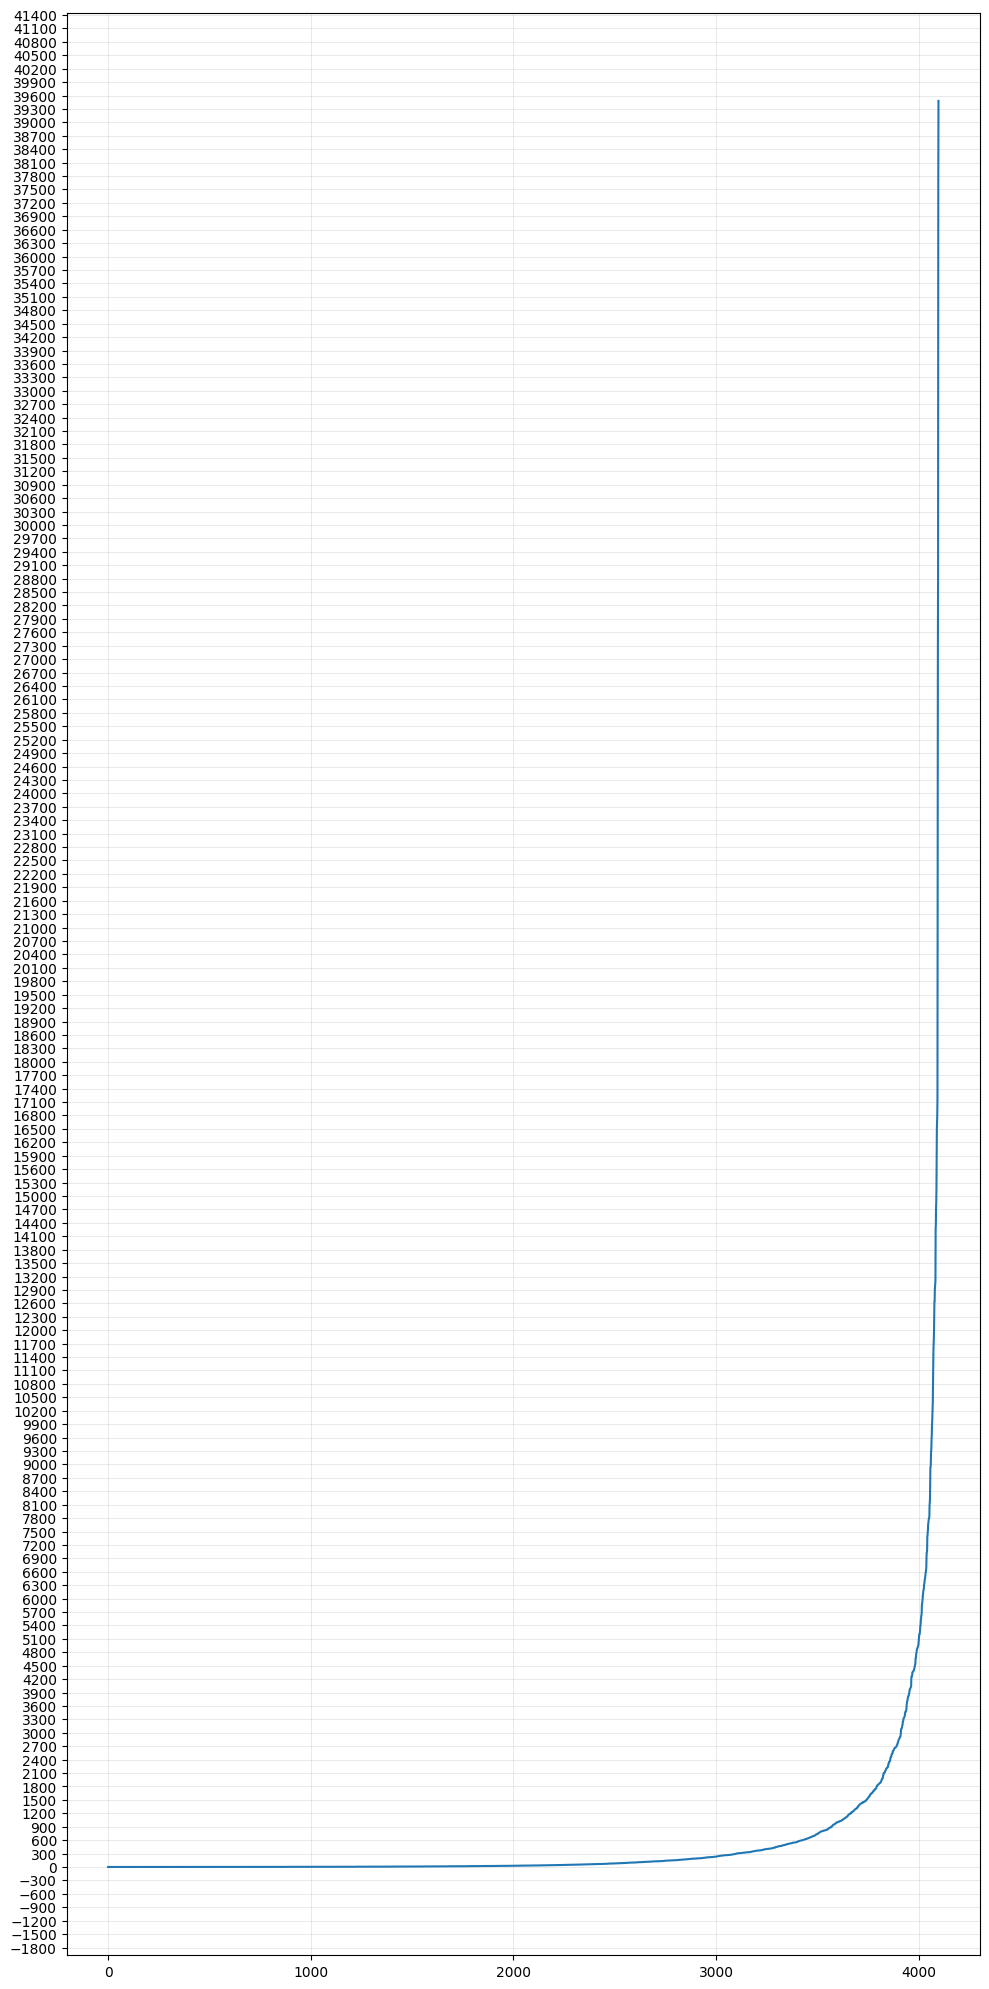

In [ ]:
# Подбираем примерно, какие категории не стоит учиться предсказывать, я думаю, что меньше 300 взаимодействий за месяц о микрокатегории это мало

series = data.groupby("microcat_id").size()
sorted_series = series.sort_values()

fig, ax = plt.subplots(figsize=(10, 20))
ax.plot(sorted_series.values)

ax.yaxis.set_major_locator(MultipleLocator(300))

ax.grid(which="major", axis="both", linewidth=0.5, alpha=0.4)
plt.tight_layout()

In [5]:
# Не будем делать рекомендации для пользователей, которые мало обоснованы. Также не стоит учиться рекомендовать слабые микрокатегории, которые редко встречаются, алгоритм вряд ли сможет уловить связи и будет зашумляться сильно прогноз

MIN_USERS_INTERACTIONS = 20
MIN_MICROCATS_INTERACTIONS = 300

users_filter = data.groupby("user_id")["item_id"].apply(lambda x: len(set(x)))

microcats_filter = data.groupby("microcat_id")["user_id"].apply(lambda x: len(set(x)))

users_filter = users_filter[users_filter > MIN_USERS_INTERACTIONS].index
microcats_filter = microcats_filter[microcats_filter > MIN_MICROCATS_INTERACTIONS].index
data = data[
    (data["user_id"].isin(users_filter)) & (data["microcat_id"].isin(microcats_filter))
]

In [6]:
# Оставляем только последнее взаимодействие пользователя с каждым итемом

data = data.sort_values(["user_id", "item_id", "event_date"]).drop_duplicates(
    subset=["user_id", "item_id"], keep="last"
)

In [7]:
# Уберем пользователей, у которых меньше 20 взаимодействий финальных (тк в первый раз мы фильтровали в целом по любым взаимодействиям учитывая даже те, что относятся к одному и тому же объекту)
# Составляем валидационную и тестовую выборки

mask = data.groupby("user_id").size() > 20
users_needed = mask[mask].index.tolist()

data = data[data["user_id"].isin(users_needed)]
test_valid = data.sort_values(["user_id", "event_date"]).groupby("user_id").tail(10)

test = test_valid.sort_values(["user_id", "event_date"]).groupby("user_id").tail(5)
valid = test_valid[~test_valid.index.isin(test.index)]
train = data[~data.index.isin(test_valid.index)]

In [8]:
# Здесь будут лежать микрокатегории, с которыми каждый пользователь провзаимодействовал в течение трейн выборки
train_microcat_interactions = (
    train.groupby("user_id")["microcat_id"].apply(lambda x: set(x)).reset_index()
)

# Оставляем на валидацию и тест только те категории по каждому пользователю, которые не встречались в трейне (чтобы мерять качество умения предсказывать новую нужную микрокатегорию в первую очередь)
all_train_microcats = set(train.microcat_id)

test_frame = test[
    test.apply(
        lambda x: (
            x.microcat_id
            not in train_microcat_interactions[
                train_microcat_interactions["user_id"] == x.user_id
            ].microcat_id.iloc[0]
        )
        and (x.microcat_id in all_train_microcats),
        axis=1,
    )
]
valid_frame = valid[
    valid.apply(
        lambda x: (
            x.microcat_id
            not in train_microcat_interactions[
                train_microcat_interactions["user_id"] == x.user_id
            ].microcat_id.iloc[0]
        )
        and (x.microcat_id in all_train_microcats),
        axis=1,
    )
]

# Соберем историю как дополнительную фичу (последние 5 вазимодействий с категориями)
last_interactions_valid = (
    train.sort_values(["user_id", "event_date"])
    .groupby("user_id")
    .apply(lambda x: list(set(x.microcat_id[-5:])))
    .reset_index()
    .rename(columns={0: "last_interactions"})
)
last_interactions_test = (
    valid.sort_values(["user_id", "event_date"])
    .groupby("user_id")
    .apply(lambda x: list(set(x.microcat_id[-5:])))
    .reset_index()
    .rename(columns={0: "last_interactions"})
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/1148558094.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: list(set(x.microcat_id[-5:])))
/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/1148558094.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: list(set(x.microcat_id[-5:])))


In [9]:
# Подготовавливаем тестовую выборку (оставляем только уникальные объявления и микрокатегории)

test_frame_info = defaultdict(list)

for user_id, tdf in test_frame.groupby("user_id"):
    item_set = set(tdf.item_id)
    microcat_set = set(tdf.microcat_id)

    test_frame_info["user_id"].append(user_id)
    test_frame_info["item_set"].append(list(item_set))
    test_frame_info["microcat_set"].append(list(microcat_set))

test_frame = pd.DataFrame(test_frame_info)

# Строим ALS рекомендацию микрокатегории

In [10]:
train_data, user_to_index, microcat_to_index = create_mappings(train)

# Перейдем везде на idx
test_frame["user_idx"] = test_frame.user_id.map(user_to_index)
test_frame["microcat_idx"] = test_frame.microcat_set.apply(
    lambda x: [microcat_to_index[e] for e in x]
)

valid_frame["user_idx"] = valid_frame.user_id.map(user_to_index)
valid_frame["microcat_idx"] = valid_frame.microcat_id.map(microcat_to_index)

/Users/alfa/Downloads/aaa-t-recs/src/model/collaborative/utils/data.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions["user_idx"] = interactions["user_id"].map(user_to_index)
/Users/alfa/Downloads/aaa-t-recs/src/model/collaborative/utils/data.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions["microcat_idx"] = interactions["microcat_id"].map(microcat_to_index)
/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/4109702585.py:9: SettingWithCopyWarning: 
A value i

In [11]:
categories["microcat_idx"] = categories.microcat_id.map(microcat_to_index)

In [12]:
# Посчитаем затухающие коэфиценты к каждому взаимодействию полльзователя с объявлениями


def compute_decay_weight(row, last_interactions, lam=0.8, beta=0.3):
    user_id = row.user_id
    cur_interaction = row.event_date

    delta_days = (
        last_interactions[last_interactions["user_id"] == user_id].event_date.iloc[0]
        - cur_interaction
    ).days
    # return 0.1 + (1 - 0.1) * np.exp(-lam * delta_days) # - экспоненциальное сильное затухание
    return 1 / (1 + beta * delta_days)  # - гиперболическое менее сильное затухание


last_interactions = train_data.groupby("user_id")["event_date"].max().reset_index()
train_data["weight"] = train_data.apply(
    lambda row: compute_decay_weight(row, last_interactions), axis=1
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/1340369698.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["weight"] = train_data.apply(


In [13]:
# Просуммируем взаимодействия внутри одной микрокатегории, чтобы учитывать этот аспект тоже, помимо затухающего взаимодействия со временем

train_data_new = defaultdict(list)

for i, tdf in train_data.groupby(["user_id", "microcat_id"]):

    tdf = tdf.sort_values("event_date")
    sample = tdf.iloc[-1, :]

    train_data_new["user_id"].append(sample.user_id)
    train_data_new["item_id"].append(sample.item_id)
    train_data_new["microcat_id"].append(sample.microcat_id)
    train_data_new["event_date"].append(sample.event_date)
    train_data_new["eid"].append(sample.eid)
    train_data_new["user_idx"].append(sample.user_idx)
    train_data_new["microcat_idx"].append(sample.microcat_idx)
    train_data_new["weight"].append(sum(tdf.weight.tolist()))

train_data_weighted = pd.DataFrame(train_data_new)

In [ ]:
# # Отнормируем веса по каждому пользователю, приведя в диапазон [0, 1] после сумиирования

# from sklearn.preprocessing import normalize

# norm_weights = []
# for i, tdf in train_data_weighted.groupby('user_id'):
#     weights = tdf['weight'].values.reshape(1, -1)
#     normed = normalize(weights, norm='l2').flatten()
#     tdf.loc[:, 'norm_weight'] = normed
#     norm_weights.append(tdf)

# train_data_weighted = pd.concat(norm_weights)

In [14]:
# Собираем спарс матрицу

user_ids = train_data_weighted.user_id.unique().tolist()
item_ids = train_data_weighted.microcat_id.unique().tolist()

rows = train_data_weighted.user_idx
cols = train_data_weighted.microcat_idx
# interactions = [1] * len(rows)
interactions = train_data_weighted.weight  # на экспериментах это дает лучшую метрику

sparse_matrix = csr_matrix(
    (interactions, (rows, cols)), shape=(len(user_ids), len(item_ids))
)

In [15]:
# Тренируем модель


def optimize_als(trial, sparse_matrix, test_frame):

    params = {
        "factors": trial.suggest_int("factors", 5, 50),
        "regularization": trial.suggest_float("regularization", 1e-3, 1, log=True),
        "alpha": trial.suggest_float("alpha", 1, 50),
        "iterations": trial.suggest_int("iterations", 10, 40),
    }

    model = implicit.als.AlternatingLeastSquares(
        factors=params["factors"],
        regularization=params["regularization"],
        iterations=params["iterations"],
        alpha=params["alpha"],
        use_native=True,
        use_cg=True,
        dtype=np.float32,
        random_state=42,
    )

    model.fit(sparse_matrix)

    user4pred = np.array([user_to_index[i] for i in test_frame.user_id.tolist()])
    recommendations, _ = model.recommend(
        user4pred, sparse_matrix[user4pred], N=100, filter_already_liked_items=True
    )
    precision = precision_at_k(
        test_frame.microcat_idx.tolist(), recommendations.tolist(), 5
    )
    recall = recall_at_k(test_frame.microcat_idx.tolist(), recommendations.tolist(), 5)
    return precision, recall


study = optuna.create_study(
    directions=["maximize", "maximize"], sampler=optuna.samplers.NSGAIISampler()
)

study.optimize(
    lambda trial: optimize_als(
        trial=trial, sparse_matrix=sparse_matrix, test_frame=test_frame
    ),
    n_trials=100,
    n_jobs=1,
)

[I 2025-06-10 15:53:16,295] A new study created in memory with name: no-name-08bf3e7f-3aa9-4fd3-9316-aab977847434
/Users/alfa/Downloads/aaa-t-recs/.venv/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 20/20 [00:01<00:00, 14.97it/s]
[I 2025-06-10 15:53:18,400] Trial 0 finished with values: [0.056940366508049, 0.14894198643312745] and parameters: {'factors': 44, 'regularization': 0.005054648816237565, 'alpha': 34.4520230213733, 'iterations': 20}.
100%|██████████| 21/21 [00:01<00:00, 14.22it/s]
[I 2025-06-10 15:53:20,373] Trial 1 finished with values: [0.05625189834970133, 0.14717525564442643] and parameters: {'factors': 47, 'regulariz

In [16]:
# Лучшие параметры для модели с взвешенными коэфицентам, затухающими со временем

for t in study.best_trials:
    print("Trial#", t.number, "→", t.values)  # t.values — кортеж метрик
    print("  Params:", t.params)

Trial# 35 → [0.062205123013060644, 0.1600334109547433]
  Params: {'factors': 34, 'regularization': 0.003027086394511927, 'alpha': 17.29662068454291, 'iterations': 26}
Trial# 60 → [0.06267085147311936, 0.15874084573588473]
  Params: {'factors': 25, 'regularization': 0.0028004937518025246, 'alpha': 13.444253383781339, 'iterations': 14}
Trial# 77 → [0.06218487394957984, 0.160588572778509]
  Params: {'factors': 36, 'regularization': 0.6443198884771337, 'alpha': 7.066787263392779, 'iterations': 18}


In [17]:
best_parameters = {'factors': 36, 'regularization': 0.6443198884771337, 'alpha': 7.066787263392779, 'iterations': 18}

In [677]:
# Лучшие параметр для модели с взаимодействиями 0 - 1

for t in study.best_trials:
    print("Trial#", t.number, "→", t.values)  # t.values — кортеж метрик
    print("  Params:", t.params)

Trial# 17 → [0.06186088893388681, 0.1545982248321015]
  Params: {'factors': 18, 'regularization': 0.024351134012825994, 'alpha': 8.988342137424372, 'iterations': 24}
Trial# 62 → [0.0603827072997874, 0.15613546623468663]
  Params: {'factors': 37, 'regularization': 0.38088206574608874, 'alpha': 9.466836257859903, 'iterations': 12}
Trial# 64 → [0.06149640579123215, 0.1546370355371064]
  Params: {'factors': 21, 'regularization': 0.033413140896961256, 'alpha': 5.247549122581711, 'iterations': 25}


In [18]:
# Лучшая модель с взвешенными скорами взаимодействий

als = implicit.als.AlternatingLeastSquares(**best_parameters)

als.fit(sparse_matrix)

100%|██████████| 18/18 [00:00<00:00, 19.50it/s]


In [19]:
# Скорим (лушчая модель - с взвешенными взимодействиями с учетом весов)

user4pred = np.array([user_to_index[i] for i in test_frame.user_id.tolist()])
recommendations, _ = als.recommend(
    user4pred, sparse_matrix[user4pred], N=100, filter_already_liked_items=True
)

test_frame["preds"] = recommendations.tolist()
print(precision_at_k(test_frame.microcat_idx.tolist(), test_frame.preds.tolist(), 5))
print(recall_at_k(test_frame.microcat_idx.tolist(), test_frame.preds.tolist(), 5))

0.062205123013060644
0.16072187911309102


# Подготавливаем выборку под обучение катбуста

In [20]:
user_vectors = als.user_factors
item_vectors = als.item_factors

user_vector_length = user_vectors[0].shape[0]
item_vector_length = item_vectors[0].shape[0]

In [21]:
microcat_to_index[-1] = -1

In [22]:
# Катбуст будет кушать: 5 последних микрокатегорий | предсказываемый кандидат | скор из ALS предсказываемого кандидата и пользователя | усредненный вектор 5 последних микрокатегорий | вектор ALS пользователя | вектор ALS таргет микрокатегории


def get_last_valid_interactions(user_id):
    res = (
        last_interactions_valid[last_interactions_valid["user_id"] == user_id]
        .iloc[0]
        .last_interactions
    )
    while len(res) != 5:
        res.append(-1)

    return res


def get_als_score(user_idx, microcat_idx):

    score = np.dot(user_vectors[user_idx], item_vectors[microcat_idx])
    return score


def get_mean_last_microcats_embed(microcat_ids):

    result_embed = item_vectors[microcat_ids].mean(axis=0).tolist()
    return result_embed


def get_user_embed(user_idx):

    return user_vectors[user_idx].tolist()


def get_microcat_embed(item_idx):

    return item_vectors[item_idx].tolist()


def create_catboost_frame(valid_frame):

    info = defaultdict(list)
    user_positive_microcats = defaultdict(list)

    for i, row in valid_frame.iterrows():

        info["user_id"].append(str(row.user_idx))

        # последние взаимодействия по микрокатегориям
        last_interactions = get_last_valid_interactions(row.user_id)
        for i, elem in enumerate(
            list(map(lambda x: str(microcat_to_index[x]), last_interactions))
        ):
            info[f"last_microcat_{i + 1}"].append(elem)

        # усредненный вектор последних 5 микрокатегорий
        mean_microcat_embed = get_mean_last_microcats_embed(
            [microcat_to_index[elem] for elem in last_interactions if elem != -1]
        )
        for i, elem in enumerate(mean_microcat_embed):
            info[f"last_microcat_embed_value_{i + 1}"].append(elem)

        # вектор пользователя
        user_embed = get_user_embed(row.user_idx)
        for i, elem in enumerate(user_embed):
            info[f"user_embed_value_{i + 1}"].append(elem)

        # вектор таргет микрокатегории
        item_embed = get_microcat_embed(row.microcat_idx)
        for i, elem in enumerate(item_embed):
            info[f"item_embed_value_{i + 1}"].append(elem)

        info["interaction_type"].append(str(row.eid))
        info["target_microcat"].append(str(row.microcat_idx))
        info["target_score"].append(get_als_score(row.user_idx, row.microcat_idx))
        info["target"].append(1)

        user_positive_microcats[row.user_id].append(row.microcat_idx)

    all_eids = valid_frame.eid.unique().tolist()
    for user_id in user_positive_microcats:

        positive_microcats = set(user_positive_microcats[user_id])
        for negative_microcat in random.sample(
            sorted(all_train_microcats - positive_microcats), 10
        ):
            new_negative_microcat = microcat_to_index[negative_microcat]

            info["user_id"].append(str(user_to_index[user_id]))

            # последние взаимодействия по микрокатегориям
            last_interactions = get_last_valid_interactions(user_id)
            for i, elem in enumerate(
                list(map(lambda x: str(microcat_to_index[x]), last_interactions))
            ):
                info[f"last_microcat_{i + 1}"].append(elem)

            # усредненный вектор последних 5 микрокатегорий
            mean_microcat_embed = get_mean_last_microcats_embed(
                [microcat_to_index[elem] for elem in last_interactions if elem != -1]
            )
            for i, elem in enumerate(mean_microcat_embed):
                info[f"last_microcat_embed_value_{i + 1}"].append(elem)

            # вектор пользователя
            user_embed = get_user_embed(user_to_index[user_id])
            for i, elem in enumerate(user_embed):
                info[f"user_embed_value_{i + 1}"].append(elem)

            # вектор таргет микрокатегории
            item_embed = get_microcat_embed(new_negative_microcat)
            for i, elem in enumerate(item_embed):
                info[f"item_embed_value_{i + 1}"].append(elem)

            info["interaction_type"].append(str(random.sample(all_eids, 1)[0]))
            info["target_microcat"].append(str(new_negative_microcat))
            info["target_score"].append(
                get_als_score(user_to_index[user_id], new_negative_microcat)
            )
            info["target"].append(0)

    return pd.DataFrame(info)


catboost_train_df = create_catboost_frame(valid_frame)

In [23]:
last_microcat_embed_values_names = [
    f"last_microcat_embed_value_{i + 1}" for i in range(item_vector_length)
]
item_embed_values_names = [
    f"item_embed_value_{i + 1}" for i in range(item_vector_length)
]
user_embed_values_names = [
    f"user_embed_value_{i + 1}" for i in range(user_vector_length)
]

In [24]:
df = catboost_train_df.copy()

cat_features = [
    "last_microcat_1",
    "last_microcat_2",
    "last_microcat_3",
    "last_microcat_4",
    "last_microcat_5",
    "target_microcat",
]

num_features = ["target_score"]

target_col = "target"

In [812]:
# Создание валидации для катбуста, собираю сюда часть из взаимодействий по категориям, в которых есть больше одного взаимодействия. Все остальное идет в трейн

pair_counts = df.groupby(["user_id", "target"])["target"].transform("count")
to_split = df[pair_counts > 1]
to_split["user_target_strata"] = (
    to_split["user_id"].astype(str) + "_" + to_split["target"].astype(str)
)

_, val_cb = train_test_split(
    to_split, test_size=0.4, random_state=42, stratify=to_split["user_target_strata"]
)

train_cb = df[~df.index.isin(val_cb.index)]

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_35343/1646250050.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_split['user_target_strata'] = to_split['user_id'].astype(str) + '_' + to_split['target'].astype(str)


# Выборка для инференса катбуста на тесте

In [25]:
def get_last_test_interactions(user_id):
    res = (
        last_interactions_test[last_interactions_test["user_id"] == user_id]
        .iloc[0]
        .last_interactions
    )
    while len(res) != 5:
        res.append(-1)

    return res


def get_catboost_inference_data(test_frame):

    info = defaultdict(list)
    for i, row in test_frame.iterrows():

        for als_microcat_pred in row.preds:

            info["user_id"].append(str(row.user_id))
            info["target_microcat"].append(str(als_microcat_pred))
            info["target_score"].append(
                get_als_score(user_to_index[row.user_id], als_microcat_pred)
            )

            # последние взаимодействия по микрокатегориям
            last_interactions = get_last_test_interactions(row.user_id)
            for i, elem in enumerate(
                list(map(lambda x: str(microcat_to_index[x]), last_interactions))
            ):
                info[f"last_microcat_{i + 1}"].append(elem)

            # усредненный вектор последних 5 микрокатегорий
            mean_microcat_embed = get_mean_last_microcats_embed(
                [microcat_to_index[elem] for elem in last_interactions if elem != -1]
            )
            for i, elem in enumerate(mean_microcat_embed):
                info[f"last_microcat_embed_value_{i + 1}"].append(elem)

            # вектор пользователя
            user_embed = get_user_embed(user_to_index[row.user_id])
            for i, elem in enumerate(user_embed):
                info[f"user_embed_value_{i + 1}"].append(elem)

            # вектор таргет микрокатегории
            item_embed = get_microcat_embed(als_microcat_pred)
            for i, elem in enumerate(item_embed):
                info[f"item_embed_value_{i + 1}"].append(elem)

    return pd.DataFrame(info)


catboost_inference_df = get_catboost_inference_data(test_frame)

## Optuna оптимизация катбуста

In [26]:
# Оптимальные параметры для CatBoost Classifier/Ranker


def sort_preds(tdf):

    microcats = tdf.target_microcat.tolist()
    model_scores = tdf.model_scores.tolist()

    pairs_model = list(zip(microcats, model_scores))
    pairs_model_sorted = sorted(pairs_model, key=lambda x: x[1], reverse=True)

    answers_model = [int(k) for (k, _) in pairs_model_sorted]

    return pd.Series({"top_model": answers_model})


def optimize_catboost(trial, train_pool, test_pool, optimizer_class):

    params = {
        "iterations": trial.suggest_int("iterations", 10, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3),
        "depth": trial.suggest_int("depth", 3, 15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 20.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": False,
    }

    if optimizer_class == "classifier":

        params["loss_function"] = "Logloss"
        model = CatBoostClassifier(**params)

    elif optimizer_class == "ranker":

        params["loss_function"] = "PairLogit"
        params["bootstrap_type"] = "Bernoulli"
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
        params.pop("bagging_temperature")
        model = CatBoostRanker(**params)

    model.fit(train_pool)

    if optimizer_class == "classifier":
        probs = model.predict_proba(test_pool)[:, 1]
    elif optimizer_class == "ranker":
        probs = model.predict(test_pool)

    catboost_inference_df["model_scores"] = probs
    catboost_results = (
        catboost_inference_df.groupby("user_id").apply(sort_preds).reset_index()
    )
    catboost_results.user_id = catboost_results.user_id.astype("int64")

    test_frame_cpy = test_frame.copy()
    test_frame_cpy = pd.merge(test_frame_cpy, catboost_results, on="user_id")

    precision = precision_at_k(
        test_frame_cpy.microcat_idx.tolist(), test_frame_cpy.top_model.tolist(), 5
    )
    recall = recall_at_k(
        test_frame_cpy.microcat_idx.tolist(), test_frame_cpy.top_model.tolist(), 5
    )

    return precision, recall

In [873]:
# Подбор параметров для Classifier


classifier_train_pool = Pool(
    data=df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=df[target_col],
    cat_features=cat_features,
)

classifier_inference_pool = Pool(
    data=catboost_inference_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

study = optuna.create_study(
    directions=["maximize", "maximize"], sampler=optuna.samplers.NSGAIISampler()
)

study.optimize(
    lambda trial: optimize_catboost(
        trial=trial,
        train_pool=classifier_train_pool,
        test_pool=classifier_inference_pool,
        optimizer_class="classifier",
    ),
    n_trials=100,
    n_jobs=1,
)

[I 2025-06-07 16:36:53,232] A new study created in memory with name: no-name-f003eefa-87b4-44f2-a9f4-d61af88a9cda
/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_35343/3392286988.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catboost_results = catboost_inference_df.groupby('user_id').apply(sort_preds).reset_index()
[I 2025-06-07 16:36:57,698] Trial 0 finished with values: [0.06092943201376936, 0.1481623974891161] and parameters: {'iterations': 71, 'learning_rate': 0.14167100105115593, 'depth': 9, 'l2_leaf_reg': 43.02569465260008, 'bagging_temperature': 0.9066824608469571, 'random_strength': 8.68075630973711, 'border_count': 190}.
/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/

In [ ]:
# Лучшие парамтеры для класифаер катбуста
for t in study.best_trials:
    print("Trial#", t.number, "→", t.values)
    print("Params:", t.params)

Trial# 38 → [0.06457426344031589, 0.16080287536701426]
  Params: {'iterations': 74, 'learning_rate': 0.07352773618266392, 'depth': 11, 'l2_leaf_reg': 87.04820527341057, 'bagging_temperature': 0.629243810867534, 'random_strength': 0.17891683830697946, 'border_count': 237}


In [31]:
best_parameters_cb_classifier = {
    "iterations": 74,
    "learning_rate": 0.07352773618266392,
    "depth": 11,
    "l2_leaf_reg": 87.04820527341057,
    "bagging_temperature": 0.629243810867534,
    "random_strength": 0.17891683830697946,
    "border_count": 237,
}

In [27]:
# Подбор параметров для Ranker

train_cb_ranker = df.sort_values("user_id").reset_index(drop=True)
ranker_train_pool = Pool(
    data=train_cb_ranker[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=train_cb_ranker[target_col],
    group_id=train_cb_ranker["user_id"],
    cat_features=cat_features,
)

ranker_inference_pool = Pool(
    data=catboost_inference_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

study = optuna.create_study(
    directions=["maximize", "maximize"], sampler=optuna.samplers.NSGAIISampler()
)

study.optimize(
    lambda trial: optimize_catboost(
        trial=trial,
        train_pool=ranker_train_pool,
        test_pool=ranker_inference_pool,
        optimizer_class="ranker",
    ),
    n_trials=100,
    n_jobs=1,
)

[I 2025-06-10 15:59:38,771] A new study created in memory with name: no-name-d3d65d68-53f3-4345-aa5f-f78399665498
/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/1196649177.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catboost_inference_df.groupby("user_id").apply(sort_preds).reset_index()
[I 2025-06-10 16:00:13,284] Trial 0 finished with values: [0.05902602004657285, 0.14649016232999224] and parameters: {'iterations': 34, 'learning_rate': 0.11297732509489984, 'depth': 15, 'l2_leaf_reg': 58.01807610100573, 'bagging_temperature': 0.5971784761594717, 'random_strength': 8.671006785766409, 'border_count': 251, 'subsample': 0.8510603089084314}.
/var/folders/3t/8pkw9rb128v3s69l

In [28]:
# Лучшие парамтеры для ранкер катбуста
for t in study.best_trials:
    print("Trial#", t.number, "→", t.values)
    print("Params:", t.params)

Trial# 35 → [0.06418953123418043, 0.15983767000776214]
Params: {'iterations': 66, 'learning_rate': 0.010891730252789271, 'depth': 14, 'l2_leaf_reg': 24.96000251715383, 'bagging_temperature': 0.7346778905934805, 'random_strength': 8.53804829473974, 'border_count': 173, 'subsample': 0.5207933598285033}
Trial# 59 → [0.06396679153589147, 0.1623350545037292]
Params: {'iterations': 63, 'learning_rate': 0.11297732509489984, 'depth': 15, 'l2_leaf_reg': 93.32025034957675, 'bagging_temperature': 0.5971784761594717, 'random_strength': 1.9655577520830536, 'border_count': 73, 'subsample': 0.8510603089084314}


In [29]:
best_parameters_cb_ranker = {'iterations': 66, 'learning_rate': 0.010891730252789271, 'depth': 14, 'l2_leaf_reg': 24.96000251715383, 'bagging_temperature': 0.7346778905934805, 'random_strength': 8.53804829473974, 'border_count': 173, 'subsample': 0.5207933598285033}

## Обучение модели ранкера

In [813]:
train_cb_ranker = df.sort_values("user_id").reset_index(drop=True)
train_pool_v0 = Pool(
    data=train_cb_ranker[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=train_cb_ranker[target_col],
    group_id=train_cb_ranker["user_id"],
    cat_features=cat_features,
)

In [814]:
model0 = CatBoostRanker(
    iterations=1000,
    learning_rate=0.02,
    depth=6,
    loss_function="PairLogitPairwise",
    random_seed=42,
    verbose=100,
    thread_count=-1,
)

In [815]:
model0.fit(train_pool_v0)

Pairwise scoring loss functions on CPU do not support one hot features. OneHotMaxSize set to 1
0:	learn: 0.6788019	total: 369ms	remaining: 6m 8s
100:	learn: 0.2745877	total: 35.3s	remaining: 5m 14s
200:	learn: 0.2508710	total: 1m 10s	remaining: 4m 38s
300:	learn: 0.2392594	total: 1m 44s	remaining: 4m 3s
400:	learn: 0.2308549	total: 2m 19s	remaining: 3m 28s
500:	learn: 0.2240407	total: 2m 54s	remaining: 2m 53s
600:	learn: 0.2180596	total: 3m 28s	remaining: 2m 18s
700:	learn: 0.2124552	total: 4m 4s	remaining: 1m 44s
800:	learn: 0.2073377	total: 4m 39s	remaining: 1m 9s
900:	learn: 0.2026979	total: 5m 15s	remaining: 34.7s
999:	learn: 0.1982941	total: 5m 50s	remaining: 0us


## Обучение модели с валидационной выборкой

In [818]:
train_pool = Pool(
    data=train_cb[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=train_cb[target_col],
    cat_features=cat_features,
)

In [819]:
val_pool = Pool(
    data=val_cb[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=val_cb[target_col],
    cat_features=cat_features,
)

In [820]:
model1 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=5,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
)

In [821]:
model1.fit(train_pool, eval_set=val_pool, use_best_model=True)

0:	test: 0.7874207	best: 0.7874207 (0)	total: 25.2ms	remaining: 25.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8570598068
bestIteration = 45

Shrink model to first 46 iterations.


## Обучение модели без валидационной выборки (вал = трейн)

In [862]:
train_pool_v2 = Pool(
    data=df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=df[target_col],
    cat_features=cat_features,
)

In [823]:
val_pool_v2 = Pool(
    data=df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=df[target_col],
    cat_features=cat_features,
)

In [ ]:
model2 = CatBoostClassifier(
    iterations=100,
    learning_rate=0.001,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
)

In [825]:
model2.fit(train_pool_v2, eval_set=val_pool_v2, use_best_model=True)

0:	test: 0.7906973	best: 0.7906973 (0)	total: 21.3ms	remaining: 2.11s
99:	test: 0.8456912	best: 0.8456912 (99)	total: 1.76s	remaining: 0us

bestTest = 0.8456911975
bestIteration = 99



## Обучение модели ранкера с лучшими параметрами

In [30]:
train_cb_ranker = df.sort_values("user_id").reset_index(drop=True)
ranker_train_pool = Pool(
    data=train_cb_ranker[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=train_cb_ranker[target_col],
    group_id=train_cb_ranker["user_id"],
    cat_features=cat_features,
)

ranker_inference_pool = Pool(
    data=catboost_inference_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

ranker = CatBoostRanker(**best_parameters_cb_ranker)
ranker.fit(ranker_train_pool)

Groupwise loss function. OneHotMaxSize set to 10
0:	total: 537ms	remaining: 34.9s
1:	total: 902ms	remaining: 28.9s
2:	total: 1.25s	remaining: 26.4s
3:	total: 1.63s	remaining: 25.3s
4:	total: 1.98s	remaining: 24.1s
5:	total: 2.34s	remaining: 23.4s
6:	total: 2.69s	remaining: 22.7s
7:	total: 2.99s	remaining: 21.7s
8:	total: 3.3s	remaining: 20.9s
9:	total: 3.69s	remaining: 20.7s
10:	total: 4.01s	remaining: 20s
11:	total: 4.36s	remaining: 19.6s
12:	total: 4.65s	remaining: 19s
13:	total: 4.94s	remaining: 18.4s
14:	total: 5.29s	remaining: 18s
15:	total: 5.72s	remaining: 17.9s
16:	total: 6.13s	remaining: 17.7s
17:	total: 6.42s	remaining: 17.1s
18:	total: 6.71s	remaining: 16.6s
19:	total: 6.81s	remaining: 15.7s
20:	total: 7.1s	remaining: 15.2s
21:	total: 7.39s	remaining: 14.8s
22:	total: 7.67s	remaining: 14.3s
23:	total: 7.83s	remaining: 13.7s
24:	total: 8.12s	remaining: 13.3s
25:	total: 8.21s	remaining: 12.6s
26:	total: 8.49s	remaining: 12.3s
27:	total: 8.79s	remaining: 11.9s
28:	total: 9.12s	

# Обучение модели класифаера с лучшими параметрами

In [50]:
classifier_train_pool = Pool(
    data=df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    label=df[target_col],
    cat_features=cat_features,
)

classifier = CatBoostClassifier(**best_parameters_cb_classifier)
classifier.fit(classifier_train_pool)

0:	learn: 0.6402135	total: 107ms	remaining: 7.78s
1:	learn: 0.5962732	total: 201ms	remaining: 7.23s
2:	learn: 0.5600317	total: 277ms	remaining: 6.56s
3:	learn: 0.5303394	total: 366ms	remaining: 6.41s
4:	learn: 0.5060025	total: 460ms	remaining: 6.35s
5:	learn: 0.4846558	total: 545ms	remaining: 6.18s
6:	learn: 0.4672079	total: 642ms	remaining: 6.14s
7:	learn: 0.4525267	total: 731ms	remaining: 6.03s
8:	learn: 0.4402904	total: 814ms	remaining: 5.88s
9:	learn: 0.4303049	total: 903ms	remaining: 5.78s
10:	learn: 0.4215246	total: 996ms	remaining: 5.71s
11:	learn: 0.4142174	total: 1.08s	remaining: 5.58s
12:	learn: 0.4079831	total: 1.16s	remaining: 5.47s
13:	learn: 0.4023013	total: 1.24s	remaining: 5.31s
14:	learn: 0.3975695	total: 1.33s	remaining: 5.23s
15:	learn: 0.3936670	total: 1.41s	remaining: 5.12s
16:	learn: 0.3898415	total: 1.5s	remaining: 5.04s
17:	learn: 0.3864221	total: 1.61s	remaining: 5s
18:	learn: 0.3838286	total: 1.7s	remaining: 4.91s
19:	learn: 0.3811817	total: 1.78s	remaining: 4

# Теперь соединим отбор кандидатов ALS вместе с реранкером CB

In [827]:
# Инференс Classifier версии
pool_inf = Pool(
    data=catboost_inference_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

probas1 = model1.predict_proba(pool_inf)[:, 1]
probas2 = model2.predict_proba(pool_inf)[:, 1]

catboost_inference_df["model1_scores"] = probas1
catboost_inference_df["model2_scores"] = probas2

In [828]:
# Инференс Ranker версии
pool_inf = Pool(
    data=catboost_inference_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

probas0 = model0.predict(pool_inf)
catboost_inference_df["model0_scores"] = probas0

In [829]:
def sort_top(tdf):

    microcats = tdf.target_microcat.tolist()
    model0_scores = tdf.model0_scores.tolist()
    model1_scores = tdf.model1_scores.tolist()
    model2_scores = tdf.model2_scores.tolist()

    pairs_model0 = list(zip(microcats, model0_scores))
    pairs_model1 = list(zip(microcats, model1_scores))
    pairs_model2 = list(zip(microcats, model2_scores))

    pairs_model0_sorted = sorted(pairs_model0, key=lambda x: x[1], reverse=True)
    pairs_model1_sorted = sorted(pairs_model1, key=lambda x: x[1], reverse=True)
    pairs_model2_sorted = sorted(pairs_model2, key=lambda x: x[1], reverse=True)

    answers_model0 = [k for (k, _) in pairs_model0_sorted]
    answers_model1 = [k for (k, _) in pairs_model1_sorted]
    answers_model2 = [k for (k, _) in pairs_model2_sorted]

    return pd.Series(
        {
            "top_model1": answers_model1,
            "top_model2": answers_model2,
            "top_model0": answers_model0,
        }
    )


catboost_results = (
    catboost_inference_df.groupby("user_id").apply(sort_top).reset_index()
)
catboost_results.user_id = catboost_results.user_id.astype("int64")

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_35343/704338563.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  catboost_results = catboost_inference_df.groupby('user_id').apply(sort_top).reset_index()


In [830]:
test_frame.drop(["top_model0", "top_model1", "top_model2"], axis=1, inplace=True)

In [831]:
test_frame = pd.merge(test_frame, catboost_results, on="user_id")

In [832]:
def correct_preds_0(row):
    return [int(pred) for pred in row.top_model0]


def correct_preds_1(row):
    return [int(pred) for pred in row.top_model1]


def correct_preds_2(row):
    return [int(pred) for pred in row.top_model2]


test_frame.top_model0 = test_frame.apply(correct_preds_0, axis=1)
test_frame.top_model1 = test_frame.apply(correct_preds_1, axis=1)
test_frame.top_model2 = test_frame.apply(correct_preds_2, axis=1)

In [833]:
# Резы реранкера

print(
    precision_at_k(test_frame.microcat_idx.tolist(), test_frame.top_model0.tolist(), 5)
)
print(recall_at_k(test_frame.microcat_idx.tolist(), test_frame.top_model0.tolist(), 5))

0.05943100131618913
0.1455198947048699


In [834]:
# Резы первой модели

print(
    precision_at_k(test_frame.microcat_idx.tolist(), test_frame.top_model1.tolist(), 5)
)
print(recall_at_k(test_frame.microcat_idx.tolist(), test_frame.top_model1.tolist(), 5))

0.05823630657082111
0.14369916641355335


In [835]:
# Резы второй модели

print(
    precision_at_k(test_frame.microcat_idx.tolist(), test_frame.top_model2.tolist(), 5)
)
print(recall_at_k(test_frame.microcat_idx.tolist(), test_frame.top_model2.tolist(), 5))

0.06192163612432924
0.15061590901420807


# Посмотрим на микрокатегории, которые выдает модель

In [ ]:
def show_res(user_id, k, pred_column):

    interactions = last_interactions_test[
        last_interactions_test.user_id == user_id
    ].last_interactions.iloc[0]
    interaction_names = [
        row.microcat_name
        for _, row in categories[
            categories["microcat_id"].isin(interactions)
        ].iterrows()
    ]
    print(f"Previous interactions: {interaction_names}")

    top_5_preds = test_frame[test_frame["user_id"] == user_id][pred_column].iloc[0][:k]
    preds_names = [
        row.microcat_name
        for i, row in categories[
            categories["microcat_idx"].isin(top_5_preds)
        ].iterrows()
    ]
    print(f"Predicted interactions: {preds_names}")

In [ ]:
user_identificator = 5310
top_k = 5

for model in ["preds", "top_model0", "top_model1", "top_model2"]:
    print(model)
    show_res(user_identificator, top_k, model)
    print()

gt = test_frame[test_frame["user_id"] == user_identificator]
print(
    f"Ground Truth: {[categories[categories['microcat_idx'] == e].microcat_name.iloc[0] for e in gt.microcat_idx.iloc[0]]}"
)

In [787]:
test_frame.user_id[:20]

0       2512
1       2770
2       3197
3       5310
4       5884
5       6155
6       6445
7       7164
8       8405
9      10561
10     16343
11     16761
12     18916
13     20547
14     22340
15     23492
16     26392
17    251968
18    252679
19    253860
Name: user_id, dtype: int64

# Продовая выдача

In [31]:
# Берем последние 5 взаимодействий по микрокатегориям от пользователя

last_interactions_prod = (
    test.sort_values(["user_id", "event_date"])
    .groupby("user_id")
    .apply(lambda x: list(set(x.microcat_id[-5:])))
    .reset_index()
    .rename(columns={0: "last_interactions"})
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/3382061757.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: list(set(x.microcat_id[-5:])))


In [32]:
# Получаем предсказания ALS

user4pred = np.array(
    [user_to_index[i] for i in last_interactions_prod.user_id.tolist()]
)
recommendations, _ = als.recommend(
    user4pred, sparse_matrix[user4pred], N=100, filter_already_liked_items=True
)

last_interactions_prod["preds"] = recommendations.tolist()

In [33]:
# Далем пул для инференса катбуста


def get_last_prod_interactions(user_id):
    res = (
        last_interactions_prod[last_interactions_prod["user_id"] == user_id]
        .iloc[0]
        .last_interactions
    )
    while len(res) != 5:
        res.append(-1)

    return res


def get_catboost_inference_data(test_frame):

    info = defaultdict(list)
    for i, row in test_frame.iterrows():

        for als_microcat_pred in row.preds:

            info["user_id"].append(str(row.user_id))
            info["target_microcat"].append(str(als_microcat_pred))
            info["target_score"].append(
                get_als_score(user_to_index[row.user_id], als_microcat_pred)
            )

            # последние взаимодействия по микрокатегориям
            last_interactions = get_last_prod_interactions(row.user_id)
            for i, elem in enumerate(
                list(map(lambda x: str(microcat_to_index[x]), last_interactions))
            ):
                info[f"last_microcat_{i + 1}"].append(elem)

            # усредненный вектор последних 5 микрокатегорий
            mean_microcat_embed = get_mean_last_microcats_embed(
                [microcat_to_index[elem] for elem in last_interactions if elem != -1]
            )
            for i, elem in enumerate(mean_microcat_embed):
                info[f"last_microcat_embed_value_{i + 1}"].append(elem)

            # вектор пользователя
            user_embed = get_user_embed(user_to_index[row.user_id])
            for i, elem in enumerate(user_embed):
                info[f"user_embed_value_{i + 1}"].append(elem)

            # вектор таргет микрокатегории
            item_embed = get_microcat_embed(als_microcat_pred)
            for i, elem in enumerate(item_embed):
                info[f"item_embed_value_{i + 1}"].append(elem)

    return pd.DataFrame(info)


catboost_prod_df = get_catboost_inference_data(last_interactions_prod)

prod_pool = Pool(
    data=catboost_prod_df[
        cat_features
        + num_features
        + last_microcat_embed_values_names
        + item_embed_values_names
        + user_embed_values_names
    ],
    cat_features=cat_features,
)

In [35]:
# Инференс катбуста
# probs_classifier = classifier.predict_proba(prod_pool)[:, 1]
probs_ranker = ranker.predict(prod_pool)

In [36]:
# catboost_prod_df["classifier_scores"] = probs_classifier
catboost_prod_df["ranker_scores"] = probs_ranker

In [37]:
# Причесывание результатов


def sort_prod(tdf, model_col):

    microcats = tdf.target_microcat.tolist()
    model_scores = tdf[model_col].tolist()

    pairs_model = list(zip(microcats, model_scores))
    pairs_model_sorted = sorted(pairs_model, key=lambda x: x[1], reverse=True)

    answers_model = [int(k) for (k, _) in pairs_model_sorted]

    return pd.Series({model_col: answers_model})


# catboost_classifier_results = (
#     catboost_prod_df.groupby("user_id")
#     .apply(sort_prod, model_col="classifier_scores")
#     .reset_index()
# )
catboost_ranker_results = (
    catboost_prod_df.groupby("user_id")
    .apply(sort_prod, model_col="ranker_scores")
    .reset_index()
)

/var/folders/3t/8pkw9rb128v3s69ldrh5nqhm0000gn/T/ipykernel_14939/662094480.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sort_prod, model_col="ranker_scores")


In [38]:
# catboost_classifier_results.user_id = catboost_classifier_results.user_id.astype(
#     "int64"
# )
catboost_ranker_results.user_id = catboost_ranker_results.user_id.astype("int64")

In [39]:
last_interactions_prod_copy = last_interactions_prod.copy()
# last_interactions_prod_copy = pd.merge(
#     last_interactions_prod_copy, catboost_classifier_results, on="user_id"
# )
last_interactions_prod_copy = pd.merge(
    last_interactions_prod_copy, catboost_ranker_results, on="user_id"
)

In [40]:
def show_res(user_id, k, pred_column):

    interactions = last_interactions_prod_copy[
        last_interactions_prod_copy.user_id == user_id
    ].last_interactions.iloc[0]
    interaction_names = [
        row.microcat_name
        for _, row in categories[
            categories["microcat_id"].isin(interactions)
        ].iterrows()
    ]
    print(f"Previous interactions: {interaction_names}")

    top_5_preds = last_interactions_prod_copy[
        last_interactions_prod_copy["user_id"] == user_id
    ][pred_column].iloc[0][:k]
    preds_names = [
        row.microcat_name
        for i, row in categories[
            categories["microcat_idx"].isin(top_5_preds)
        ].iterrows()
    ]
    print(f"Predicted interactions: {preds_names}")

In [46]:
user_identificator = 1893593250002
top_k = 5

for model in ["preds", "ranker_scores"]:
    print(model)
    show_res(user_identificator, top_k, model)
    print()

preds
Previous interactions: ['Другое', 'Услуги парикмахера', 'Сумки', 'Фрукты и ягоды']
Predicted interactions: ['Брюки', 'Пиджаки и костюмы', 'СПА-услуги, массаж', 'Спортивные костюмы', 'Толстовки и свитшоты']

ranker_scores
Previous interactions: ['Другое', 'Услуги парикмахера', 'Сумки', 'Фрукты и ягоды']
Predicted interactions: ['Другое', 'Нижнее бельё', 'Обслуживающий персонал в общепите', 'Административный персонал', 'Ремни, пояса, подтяжки']



In [43]:
last_interactions_prod_copy

,user_id,last_interactions,preds,ranker_scores
0,558,"[304851500001, 5997, -1, -1, -1]","[56, 39, 458, 194, 176, 294, 533, 11, 30, 248,...","[248, 34, 445, 193, 465, 165, 196, 287, 475, 1..."
1,2512,"[304851500001, 4562, 591684000001, -1, -1]","[57, 37, 165, 211, 210, 40, 10, 156, 1, 587, 9...","[494, 165, 10, 213, 156, 504, 287, 57, 364, 58..."
2,2770,"[605520500001, 242818500001, 2477, 36283525000...","[125, 322, 246, 83, 50, 283, 39, 178, 61, 75, ...","[147, 145, 597, 489, 61, 561, 62, 122, 611, 75..."
3,2892,"[5231, 10750010, 5927, -1, -1]","[10, 162, 165, 57, 155, 261, 8, 156, 159, 151,...","[165, 10, 156, 36, 248, 57, 163, 155, 159, 8, ..."
4,3197,"[350670000001, 7464, 140, 422416750001, 377458...","[211, 165, 11, 156, 57, 10, 40, 13, 453, 30, 1...","[164, 515, 372, 33, 156, 165, 10, 15, 57, 453,..."
...,...,...,...,...
12220,1882254250017,"[538453750001, 538458000002, 538452000003, -1,...","[286, 282, 531, 462, 429, 638, 627, 639, 414, ...","[446, 629, 631, 638, 639, 627, 531, 429, 414, ..."
12221,1886154250032,"[362835000001, 362831000001, 389715000002, 362...","[51, 424, 221, 338, 158, 214, 325, 486, 451, 1...","[542, 500, 368, 320, 561, 323, 413, 163, 601, ..."
12222,1886636250009,"[1941, -1, -1, -1, -1]","[288, 422, 71, 66, 40, 13, 289, 403, 46, 420, ...","[524, 422, 535, 16, 460, 526, 420, 525, 419, 6..."
12223,1887240500026,"[538456750001, -1, -1, -1, -1]","[545, 546, 531, 462, 547, 615, 429, 638, 627, ...","[446, 629, 638, 631, 546, 627, 639, 531, 547, ..."
